# HW9 - Assignment 1
## Time Series Analysis

For this assignment we use data from the MTA Subway Fares. It is logged of card swipes for 600 Manhattan stations and 23 different card types. Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014.

In [86]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [99]:
# loading data and inspecting data shape
mtaRides = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')
mtaRides.shape

(600, 23, 194)

In [102]:
#changing array values to floats to make it possible to substitute -1 with nan
# -1 representing missing data
mtaRides = mtaRides.astype(float)

In [103]:
def num_to_nan(three_d_array, number):
    """
    This function takes in a 3 dimensional array and a number and substitutes
    every instance of the number with nan
    """
    for i in range(0, len(three_d_array)):
        for n in range (0, len(three_d_array[i])):
            for x in range (0, len(three_d_array[i][n])):
                if three_d_array[i][n][x] == number:
                    three_d_array[i][n][x] = np.nan
                    
# changing -1 to nan
num_to_nan(mtaRides, -1)

In [104]:
#one can sum time series for all stations
print (mtaRides.shape)
mta_allsum_stations = np.nansum(mtaRides, axis=0)
print (mta_allsum_stations.shape)
#or for all ride types
mta_allsum_types = np.nansum(mtaRides, axis=1)
print (mta_allsum_types.shape)

(600, 23, 194)
(23, 194)
(600, 194)


## Data munging

In [105]:
# creating dataframes for all stations and all card types with a datecolumn
cardtypes = pd.DataFrame(mta_allsum_stations).transpose()
cardtypes['date'] = pd.date_range(start='2010-05-21', periods=len(cardtypes), freq='w')
cardtypes.set_index(['date'], inplace=True)

stations = pd.DataFrame(mta_allsum_types).transpose()
stations['date'] = pd.date_range(start='2010-05-21', periods=len(stations), freq='w')
stations.set_index(['date'], inplace=True)

## Task 1: Event detection
### Identify the most prominent event of the data.

### Visual inspection of the data
We begin by plotting a few arbitrary time series to inspect the data. First we plot 4 different MTA stations for the duration of the data and then 4 different card types for the duration of the data.

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

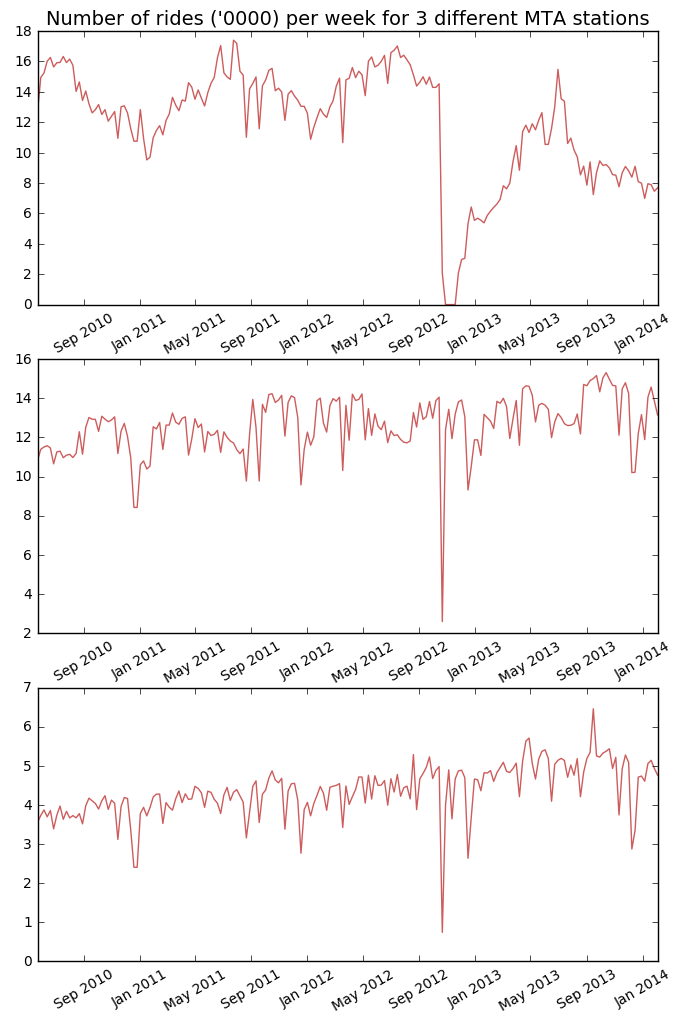

In [106]:
# plotting three random mta stations to visually inspect data
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.set_title('Number of rides (\'0000) per week for 3 different MTA stations', size=14)
ax.axis('off')

ax1 = fig.add_subplot(311)
plt.plot(stations[0]/10000, color="IndianRed")
plt.xticks(rotation=30)

ax2 = fig.add_subplot(312)
plt.plot(stations[100]/10000, color="IndianRed")
plt.xticks(rotation=30)

ax3 = fig.add_subplot(313)
plt.plot(stations[300]/10000, color="IndianRed")
plt.xticks(rotation=30)

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

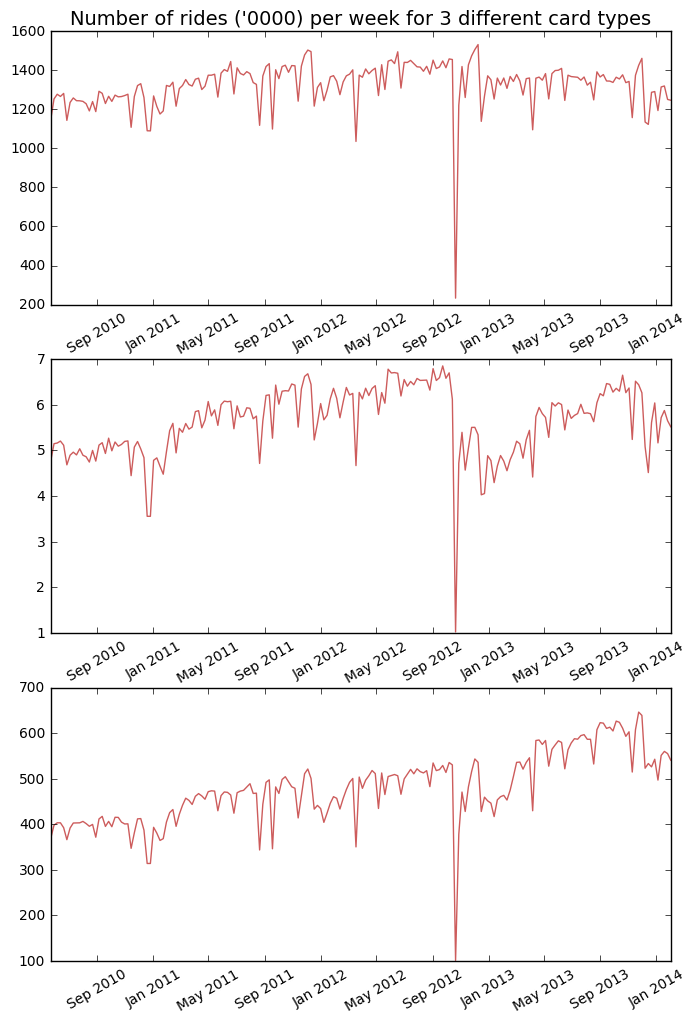

In [8]:
# plotting three random mta card type to visually inspect data
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.set_title('Number of rides (\'0000) per week for 3 different card types', size=14)
ax.axis('off')

ax1 = fig.add_subplot(311)
plt.plot(cardtypes[0]/10000, color="IndianRed")
plt.xticks(rotation=30)

ax2 = fig.add_subplot(312)
plt.plot(cardtypes[2]/10000, color="IndianRed")
plt.xticks(rotation=30)

ax3 = fig.add_subplot(313)
plt.plot(cardtypes[5]/10000, color="IndianRed")
plt.xticks(rotation=30)

Looking at data for both different stations and different card types it seems obvious we have some sort of an anomaly between Sep 2012 and Jan 2013 which requires further investigation. 

### Taking a closer look at card type 1 (10 trip card)

In [9]:
# working on card type one
print "Calculating the mean, stdev and 3-sigma threshold for card type 1"
print "Mean rides per week {:.2f}".format(np.nanmean(cardtypes[0]))
print ("Stdev rides per week {:.2f}".format(np.nanstd(cardtypes[0])))
thresholds = [np.nanmean(cardtypes[0]) - 
              3 * np.nanstd(cardtypes[0]), 
              np.nanmean(cardtypes[0]) + 
              3 * np.nanstd(cardtypes[0])]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

Calculating the mean, stdev and 3-sigma threshold for card type 1
Mean rides per week 13242372.97
Stdev rides per week 1212509.30
3-sigma thresholds 9604845.06 16879900.88


In [10]:
print len(cardtypes[0])
print len(cardtypes.index)

194
194


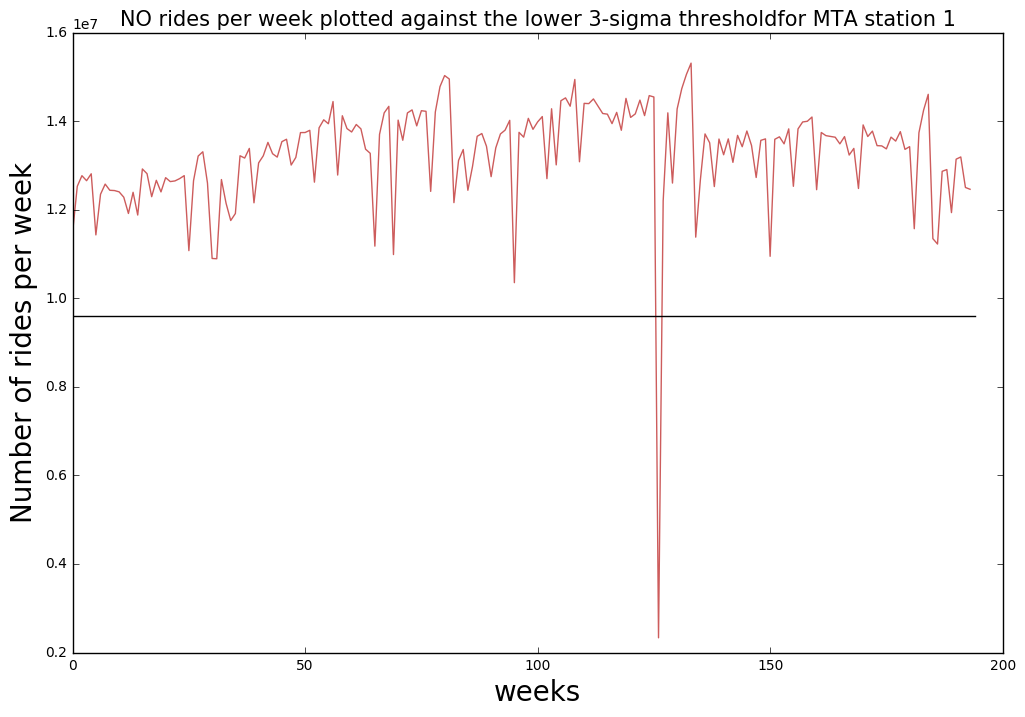

In [11]:
# working on card type one
fig = plt.figure(figsize=(12,8))
ax =plt.plot(mta_allsum_stations[0], color="IndianRed")
plt.plot([0, 194], [thresholds[0], thresholds[0]], color='k')
plt.title('NO rides per week plotted against the lower 3-sigma threshold' +
          'for MTA station 1', size=15)
plt.xlabel('weeks', size=20)
plt.ylabel('Number of rides per week', size=20)

From the plot we see that the dip in admissions is more than 3 standard deviations from the average number of rides per week for the station. We can therefor classify this as an event.

In [12]:
print 'Figuring out when the drop in number of rides occurs'
print 'According to the data the lowest number of rides is found at:'
print cardtypes[0].argmin()

Figuring out when the drop in number of rides occurs
According to the data the lowest number of rides is found at:
2012-10-21 00:00:00


Hurricane Sandy hit New York full force on October 28th 2012. That's the week following the timestamp from above so we conclude that is the event that took place and caused a dramatic decline in subway usage.

### Hurricane Sandy hits New York
see: https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_New_York

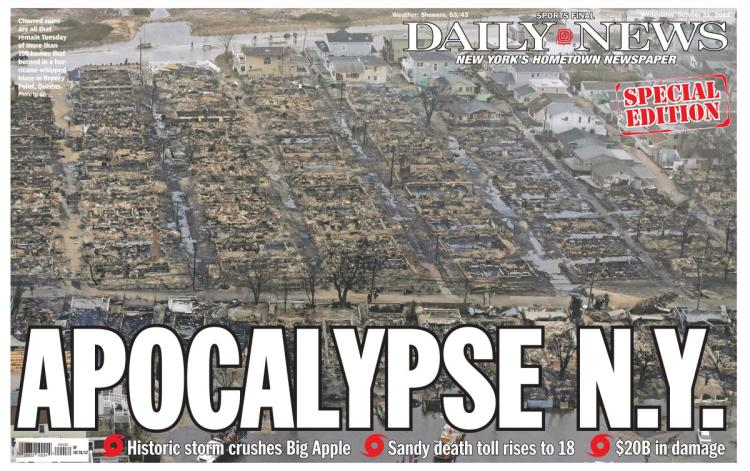

In [13]:
from IPython.core.display import Image, display
display(Image('daily-news-front-page-hurricane-sandy.jpg', width=600, unconfined=True))

## Task 2: Trends
### Identifying ridership types that have steadily increased in popularity, and that have steadily decreased.

In [14]:
# a list of the 23 different subway card types
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']
type(ridetype)

list

In [15]:
# creating a dataframe with information about each card option
dataframe_cardtype = pd.DataFrame(mta_allsum_stations).transpose()
dataframe_cardtype.columns = ridetype
dataframe_cardtype.head(3)

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0


We use a Augmented Dickey-Fuller (ADFuller) test to see if our time series have a unit root or not. No unit root generally means stationarity.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
above a critical size, then we cannot reject that there is a unit root.

    * H0: There is a unit root.
    * HA: There isn't a unit root.
    * Alpha = 0.05.

In [16]:
# creating a new dataframe to store results from ADFuller test
df = pd.DataFrame(ridetype)
df.rename(columns={0 : 'card_type'}, inplace=True)

In [17]:
dataframe_cardtype.head(2)

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0


In [18]:
# performing ADFuller test on all 23 subwaycard types and appending to a list

pValues = []

for i in dataframe_cardtype:
    temp = sm.tsa.adfuller(dataframe_cardtype[i])
    pValues.append(temp[1])

In [19]:
# creating new columns
df['pvalues'] = pValues
df['H0_reaction'] = 0

In [20]:
df['H0_reaction'] = 0

In [21]:
# comparing p-values and alpha
alpha = 0.05

for i in range(0, len(df)):
    if df.pvalues[i] <= alpha:
        df.H0_reaction[i] = "Reject null"
    else:
        df.H0_reaction[i] = "Don't Reject null"

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
df

,card_type,pvalues,H0_reaction
0,10t,1.143363e-20,Reject null
1,14d,2.229081e-01,Don't Reject null
2,1d,2.327939e-01,Don't Reject null
3,2t,2.987132e-17,Reject null
4,30d,1.771490e-03,Reject null
5,7d,5.258733e-01,Don't Reject null
6,ada,2.662643e-16,Reject null
7,afas,8.688103e-02,Don't Reject null
8,exp,3.296651e-02,Reject null
9,ez,1.184605e-01,Don't Reject null


According to the table above we can reject the Null Hypothesis of a unit root for a 10-trip card, 2-trip card, 30 day card, ADA card, Express card, Transit Check Metrocard (TCMC), ticket and unlimited card. In other words we draw the conclusion that ridership of those cardtypes seems to be stationary over the time period examined.

We take a closer look at the other 15 cardtypes.

To see which ridership types have increased in popularity and which have decreased we will need to inspect those types further.

In [23]:
dataframe_nonstationary = dataframe_cardtype[[
        '14d', '1d', '7d', 'afas', 'ez', 'ff', 'mc', 'mr', 'month', 
        'rfm', 'rr', 'sen', 'spec', 'xbus', 'stud']]
dataframe_nonstationary.head()

,14d,1d,7d,afas,ez,ff,mc,mr,month,rfm,rr,sen,spec,xbus,stud
0,530524.0,47801.0,3697443.0,10063.0,512032.0,35898.0,119881.0,4.0,123134.0,790110.0,59809.0,28221.0,0.0,358.0,0.0
1,583533.0,51486.0,3981808.0,11847.0,578023.0,44577.0,143569.0,3.0,151948.0,908068.0,69209.0,32333.0,0.0,474.0,0.0
2,586194.0,51636.0,4033030.0,12277.0,615537.0,45842.0,136383.0,12.0,151538.0,914124.0,69574.0,32618.0,0.0,465.0,0.0
3,562602.0,52063.0,4032753.0,11221.0,606270.0,44271.0,134418.0,6.0,147094.0,902549.0,68099.0,32404.0,0.0,484.0,0.0
4,548858.0,51153.0,3925446.0,10515.0,563446.0,41636.0,136351.0,9.0,137888.0,855573.0,66377.0,31933.0,176.0,452.0,0.0


In [24]:
# creating a new column to store ratios
df['ratio'] = 0.0

In [25]:
#calculating ratio between first 10 and last 10 weeks

for i,n in enumerate(dataframe_cardtype):
    first_ten = 0
    last_ten = 0
    for x in range(0,10):
        first_ten += dataframe_cardtype[n][x]
        last_ten += dataframe_cardtype[n][len(dataframe_cardtype[n])-1-x]
    df.ratio[i] = last_ten/first_ten

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
df

,card_type,pvalues,H0_reaction,ratio
0,10t,1.143363e-20,Reject null,1.021798e+00
1,14d,2.229081e-01,Don't Reject null,1.252065e+00
2,1d,2.327939e-01,Don't Reject null,1.111345e+00
3,2t,2.987132e-17,Reject null,9.338034e-01
4,30d,1.771490e-03,Reject null,1.033787e+00
5,7d,5.258733e-01,Don't Reject null,1.389748e+00
6,ada,2.662643e-16,Reject null,8.998413e-01
7,afas,8.688103e-02,Don't Reject null,2.094470e-04
8,exp,3.296651e-02,Reject null,1.068703e-05
9,ez,1.184605e-01,Don't Reject null,1.501956e-06


### Plotting smoothed curves of selected card types

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


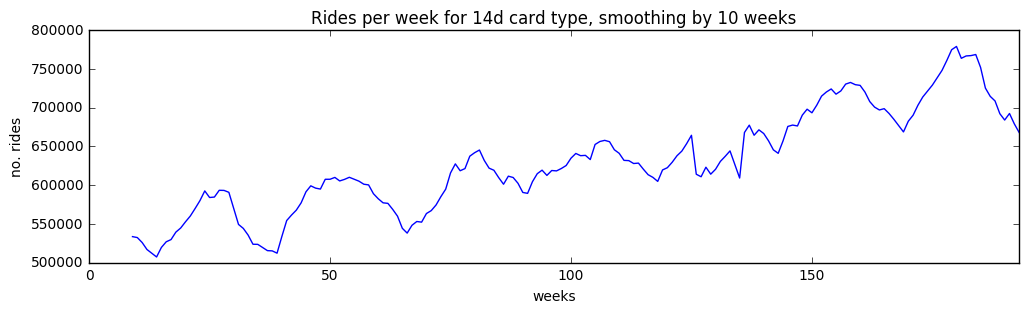

In [27]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['14d'], 10).plot()
plt.title("Rides per week for 14d card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


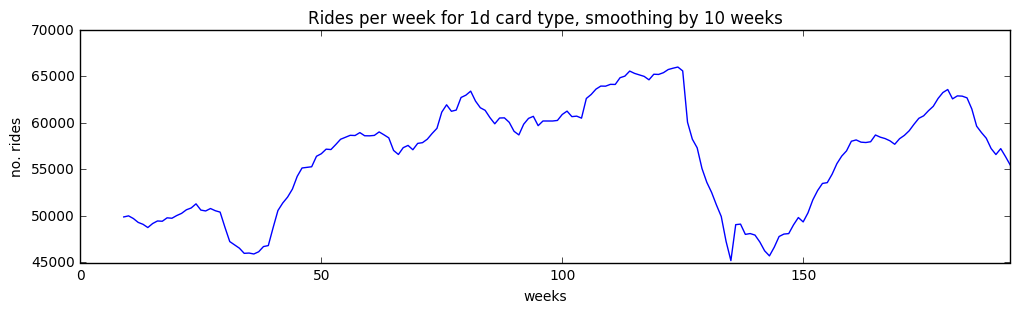

In [28]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['1d'], 10).plot()
plt.title("Rides per week for 1d card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### No trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


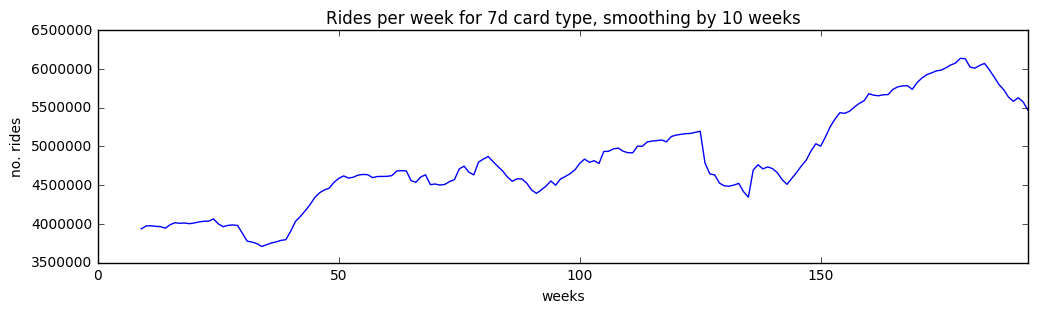

In [29]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['7d'], 10).plot()
plt.title("Rides per week for 7d card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


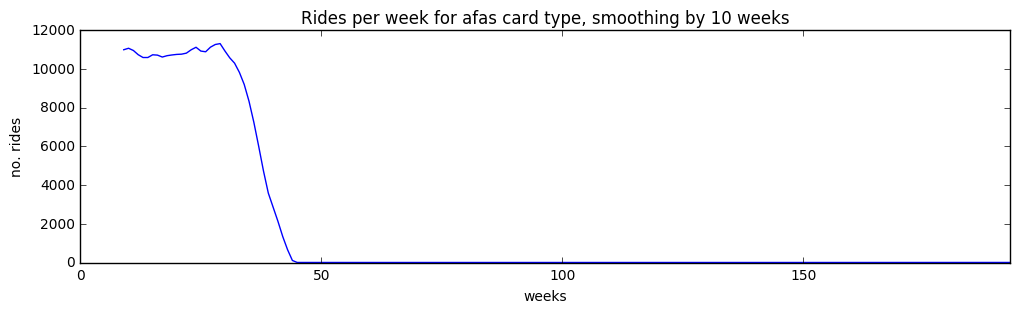

In [30]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['afas'], 10).plot()
plt.title("Rides per week for afas card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


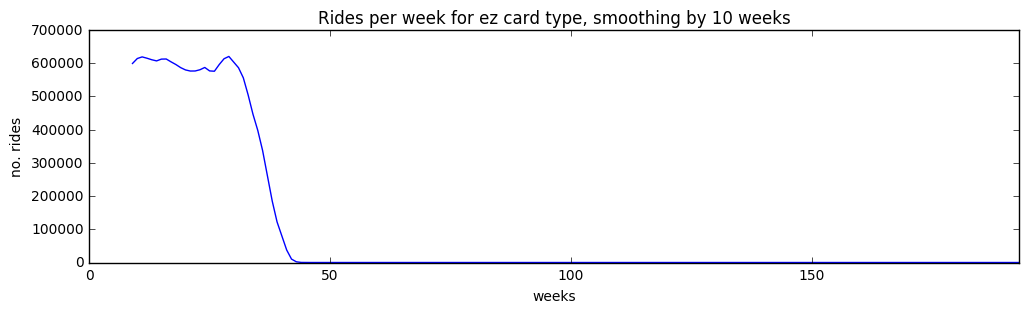

In [31]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['ez'], 10).plot()
plt.title("Rides per week for ez card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


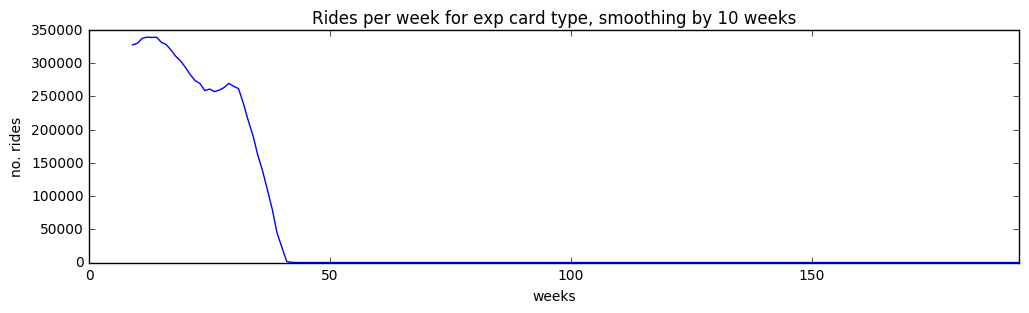

In [32]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['exp'], 10).plot()
plt.title("Rides per week for exp card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


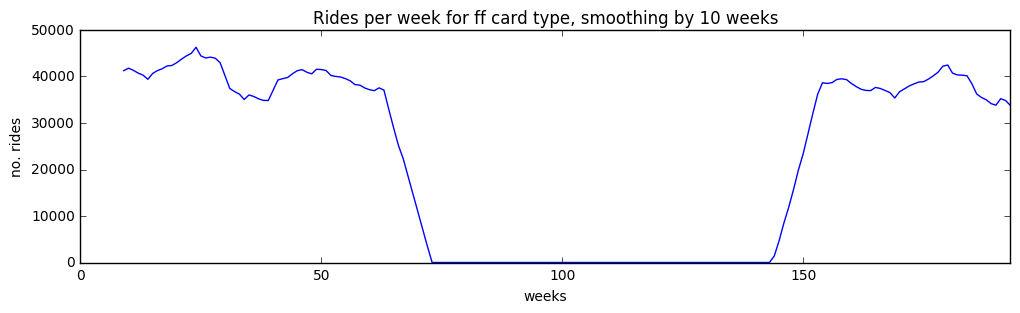

In [33]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['ff'], 10).plot()
plt.title("Rides per week for ff card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### No trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


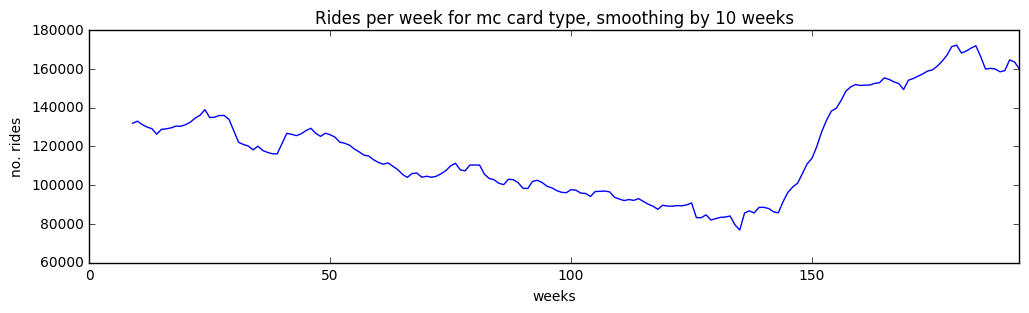

In [34]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['mc'], 10).plot()
plt.title("Rides per week for mc card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


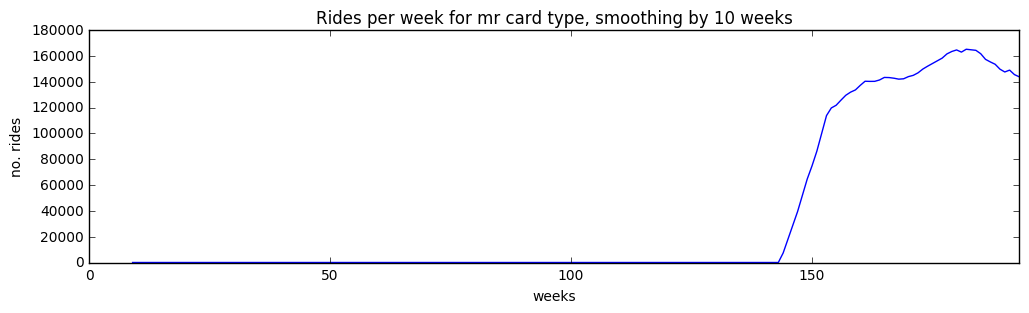

In [35]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['mr'], 10).plot()
plt.title("Rides per week for mr card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


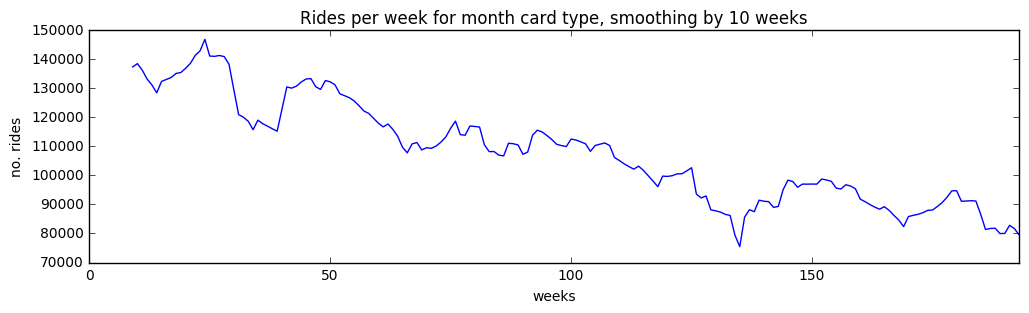

In [36]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['month'], 10).plot()
plt.title("Rides per week for month card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Downwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


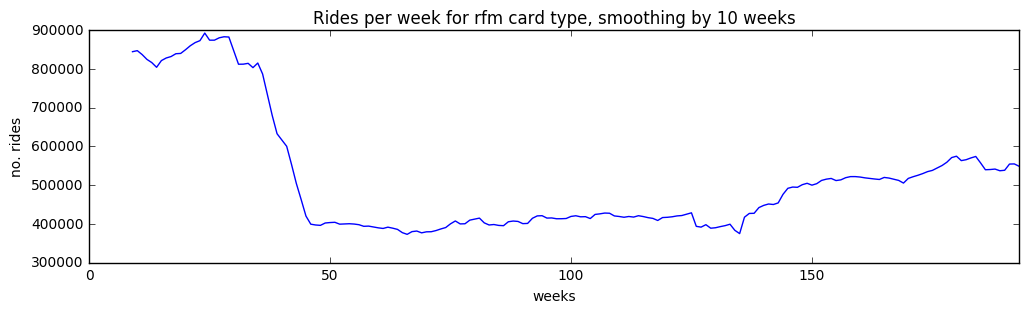

In [37]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['rfm'], 10).plot()
plt.title("Rides per week for rfm card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Structural change, no trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


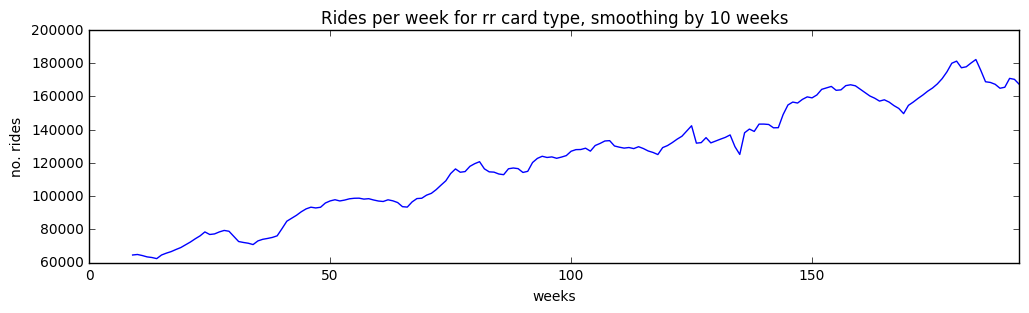

In [38]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['rr'], 10).plot()
plt.title("Rides per week for rr card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


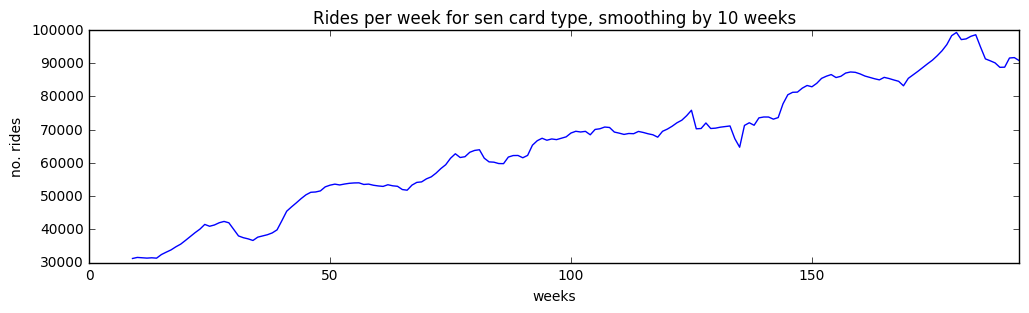

In [39]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['sen'], 10).plot()
plt.title("Rides per week for sen card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


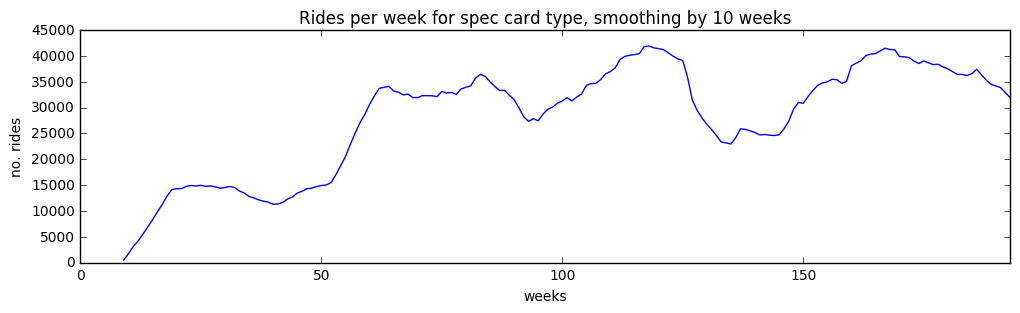

In [40]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['spec'], 10).plot()
plt.title("Rides per week for spec card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trends

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  from ipykernel import kernelapp as app


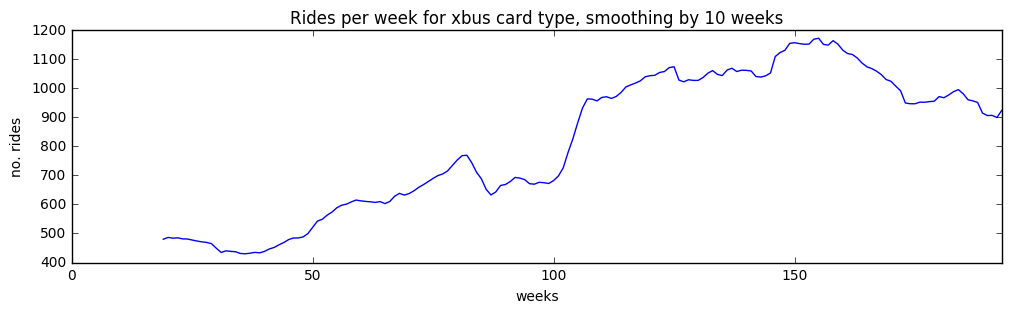

In [41]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['xbus'], 20).plot()
plt.title("Rides per week for xbus card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### Upwards trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


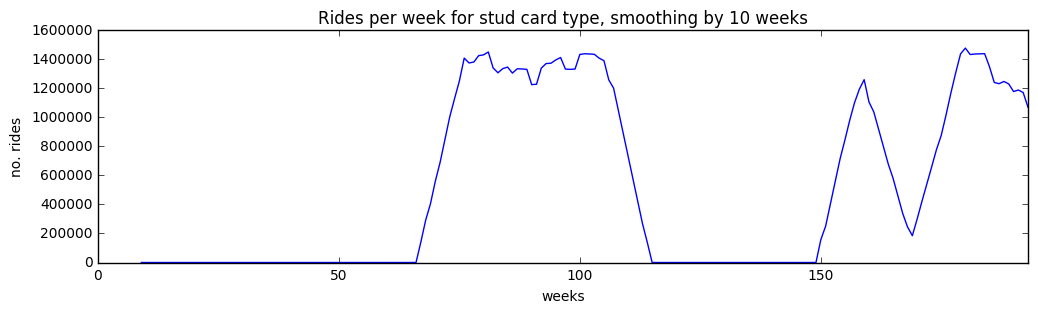

In [42]:
fig = plt.figure(figsize=(12,3))
ax = pd.rolling_mean(dataframe_cardtype['stud'], 10).plot()
plt.title("Rides per week for stud card type, smoothing by 10 weeks")
plt.xlabel("weeks")
plt.ylabel("no. rides")

#### No trend

## Results

### According to the results from the ADFuller test, visual inspection of the data and calculation of the ratio of the number of swipes for the last ten weeks to the first ten weeks we conclude that 14d, 7d, rr, sen, spec and xbus card types show an upwards trend. Only the month type shows a downwards trend. 

### According to the calculated ratio the card type that usage has increased the most is the spec card type (special). Again the only card to have a downward trent is the month card.

## Task 3: Periodicity
### Identifying the 4 stations that show the most prominent periodic trend on an annual period.

#### Let's begin by inspecting the first station of the dataset

There are n = 194 datapoints in the series


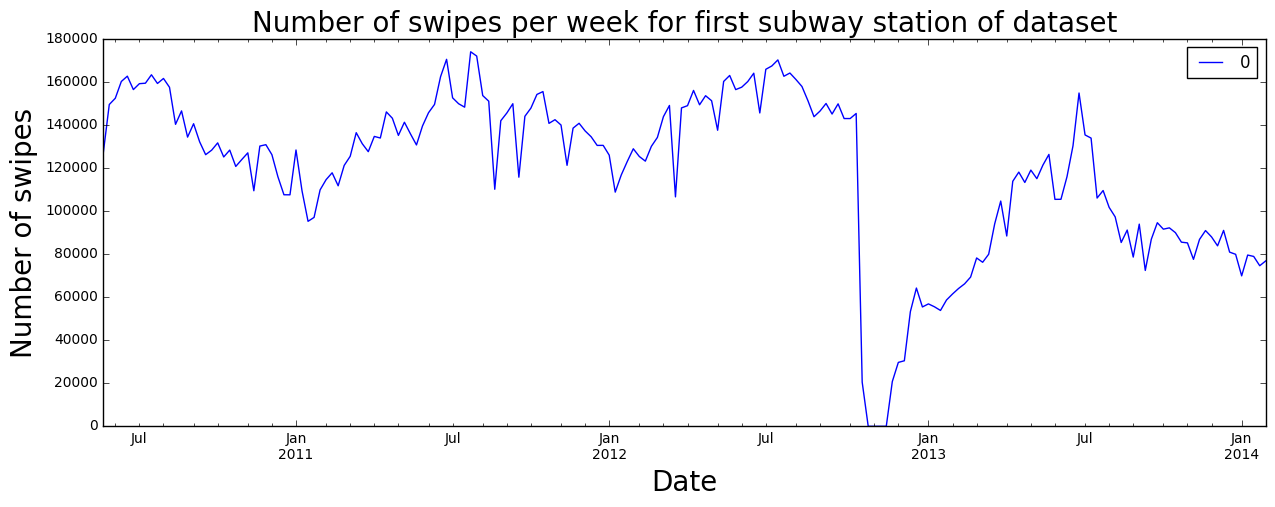

In [43]:
# plotting nr. of card swipes for the first station of the dataset
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
N = len(stations)
print ("There are n = %d datapoints in the series"%N)

ax = stations.plot(x=stations.index, y=0, ax=ax)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of swipes", fontsize=20)
plt.title("Number of swipes per week for first subway station of dataset", 
         fontsize=20)

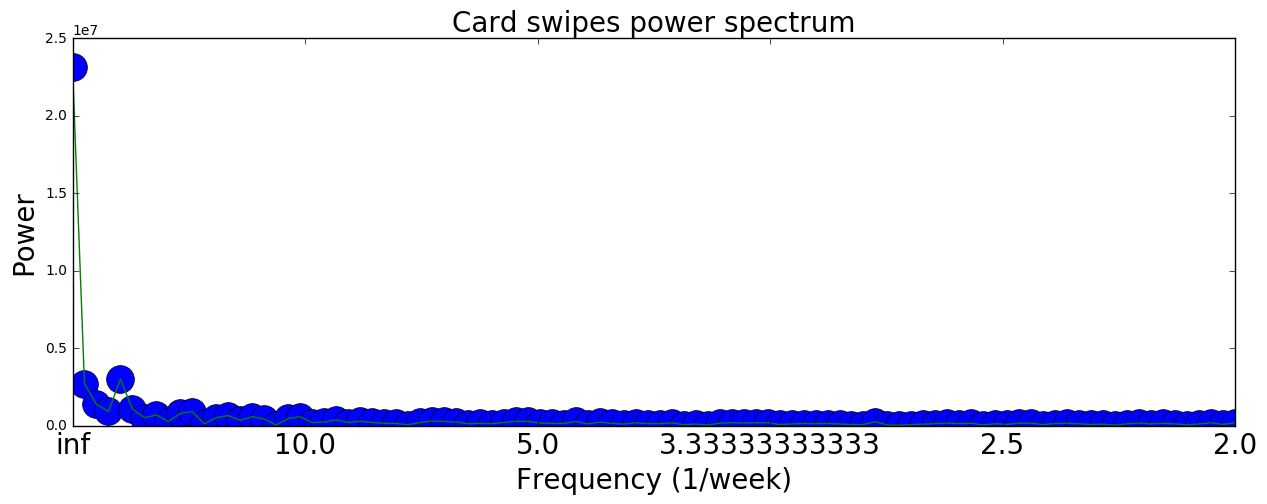

In [44]:
# Plotting the power spectrum
f = np.abs(np.fft.rfft(stations[0]))
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.xlabel("Frequency (1/week)", fontsize=20)
plt.title("Card swipes power spectrum", fontsize=20)

The first two frequencies caculated are infinity (1.0/0)  and the frequency corresponding to the entire duration of the series = N\*d, and should be removed because they are uninteresting. That's what we do in the next plot.

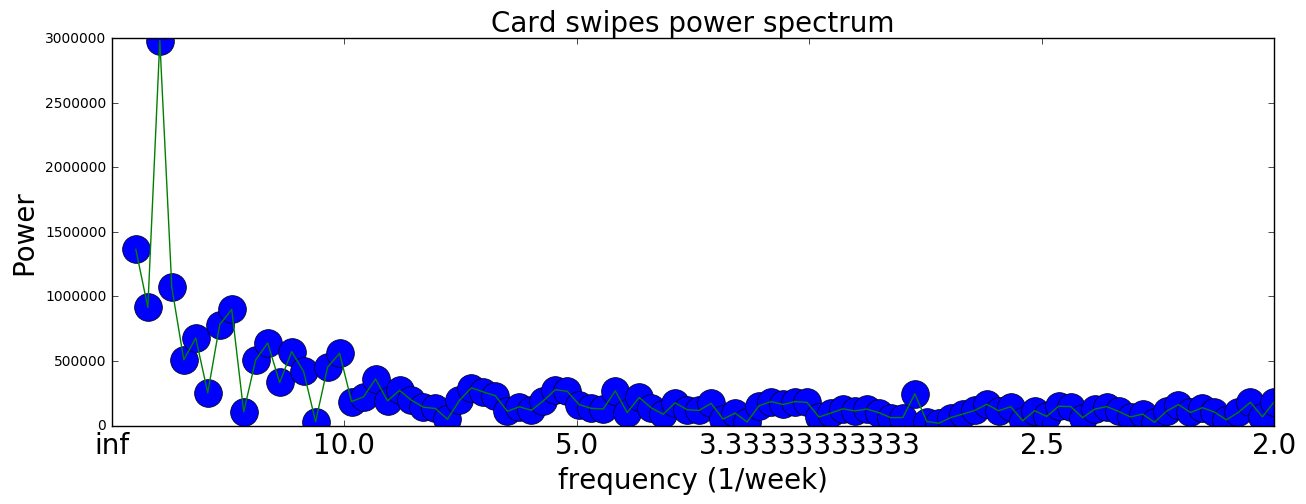

In [45]:
# getting rid of the first value (inf) for closer inspection
f = np.abs(np.fft.rfft(stations[0]))
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.xlabel("frequency (1/week)", fontsize=20)
plt.title("Card swipes power spectrum", fontsize=20)

There are miniture fluctuations in the data before the 10th data point. In the next plot we remove the first 9 weeks to realize the flutctuations better.

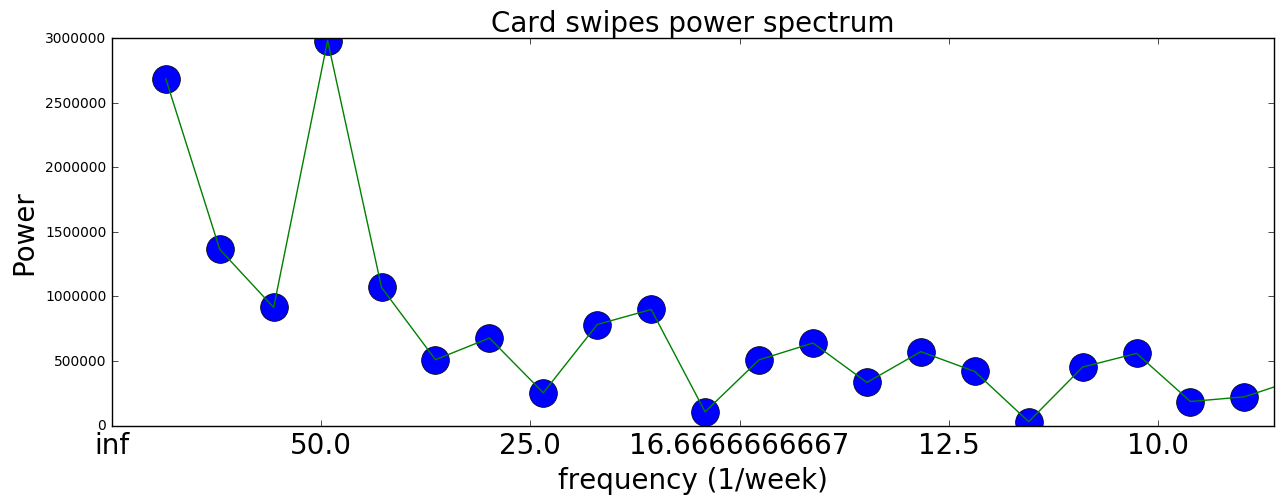

In [46]:
# getting rid of the first 9 datapoints as there seems to be 
# very little happening there
f = np.abs(np.fft.rfft(stations[0]))
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xlim(0,1.0/9)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.xlabel("frequency (1/week)", fontsize=20)
plt.title("Card swipes power spectrum", fontsize=20)

From the plot it seems the most prominent periodic trend of the data is an annual one (at least for this station). Next we plot all the stations to see if this is a one off or a common trend.

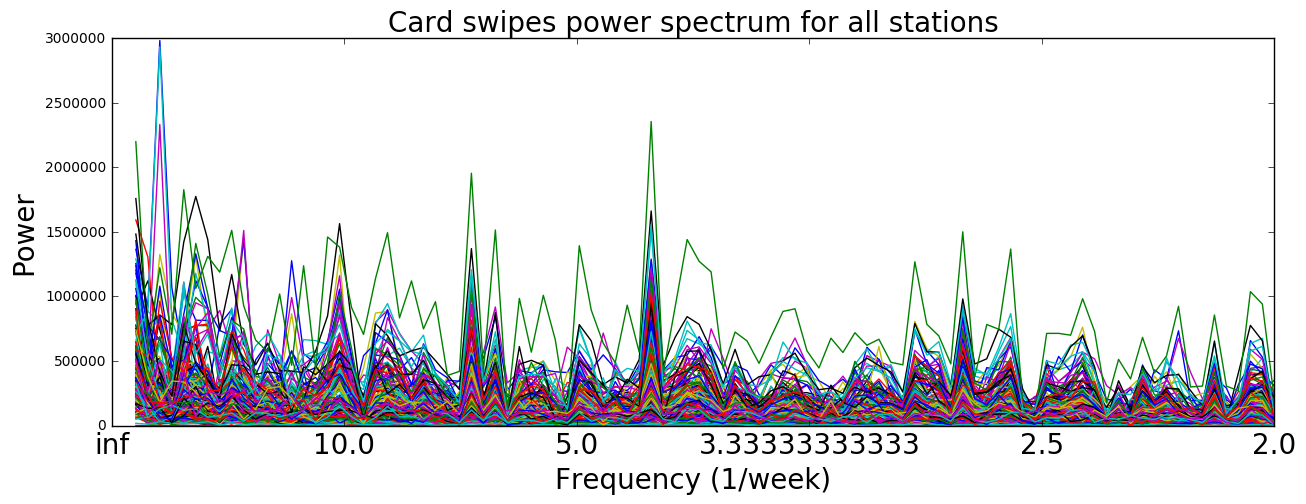

In [47]:
# PLotting the power spectrum of all subway stations together
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(0, N):
    f = np.abs(np.fft.rfft(mta_allsum_types[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-')
    
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.xlabel("Frequency (1/week)", fontsize=20)
plt.title("Card swipes power spectrum for all stations", fontsize=20)

The most prominent tops seem to match our earlier findings although there seems to be a roughly monthly periodic trend as well.

In [48]:
# looking at frequency
1/np.fft.rfftfreq(N, 1.0)

array([          inf,  194.        ,   97.        ,   64.66666667,
         48.5       ,   38.8       ,   32.33333333,   27.71428571,
         24.25      ,   21.55555556,   19.4       ,   17.63636364,
         16.16666667,   14.92307692,   13.85714286,   12.93333333,
         12.125     ,   11.41176471,   10.77777778,   10.21052632,
          9.7       ,    9.23809524,    8.81818182,    8.43478261,
          8.08333333,    7.76      ,    7.46153846,    7.18518519,
          6.92857143,    6.68965517,    6.46666667,    6.25806452,
          6.0625    ,    5.87878788,    5.70588235,    5.54285714,
          5.38888889,    5.24324324,    5.10526316,    4.97435897,
          4.85      ,    4.73170732,    4.61904762,    4.51162791,
          4.40909091,    4.31111111,    4.2173913 ,    4.12765957,
          4.04166667,    3.95918367,    3.88      ,    3.80392157,
          3.73076923,    3.66037736,    3.59259259,    3.52727273,
          3.46428571,    3.40350877,    3.34482759,    3.28813

The closest we get to a yearly frequency is 48.5 weeks. We look into that figure further.

In [83]:
powerlist = []
for i in range(0, len(mta_allsum_types)):
    powerlist.append(np.abs(np.fft.rfft(mta_allsum_types[i]))[4])

In [84]:
power_df = pd.DataFrame(powerlist)
power_df.rename(columns={0 : "power"}, inplace=True)

In [85]:
power_df.sort(columns='power', ascending=False).head(4)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,power
0,2.980161e+06
194,2.950389e+06
150,2.931896e+06
327,2.402219e+06


### The four stations with the highest seasonal periodicity are stations 0, 194, 150 and 327.